In [1]:
import gym
import numpy as np

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Prototyper
from piaget import init_env, play, box_colors

Let's play a few frames of Breakout.

First, we make the environment:

In [25]:
random_seed = 3
np.random.seed(random_seed)
env = gym.make('BreakoutNoFrameskip-v4'); num_wait_steps=1;

[2017-07-17 21:36:31,039] Making new env: BreakoutNoFrameskip-v4


Now we play.  The play() function will return a MoverTracker object, which will also be pickled and placed in the mt_dir directory.

In [26]:
num_steps = 5
img_dir = 'img/'
mt_dir = 'mt/'

mt = play(num_steps, env, img_dir, mt_dir, num_wait_steps, breakout=True)

# note: the function of the breakout=True kwarg is to let Piaget assume a few things 
# specific to Breakout's Atari/gym implementation, namely that you have to perform 
# action "1" to request a new ball when there is no ball on the screen, and that
# (unlike in some games) there is no waiting period before the game starts

# I mention this to clarify that I'm not giving Piaget info about Breakout's *dynamics*
# or *appearance*

Here's what Piaget saw, and the movers (i.e. objects) it identified.  The numbers are mover IDs, which identify persistent objects across multiple frames.


 Frame: 0


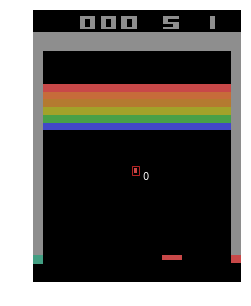


 Frame: 1


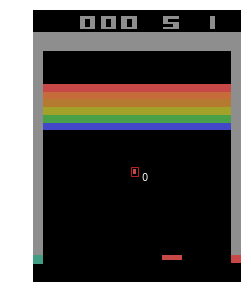


 Frame: 2


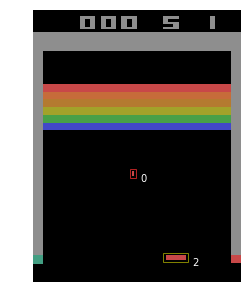


 Frame: 3


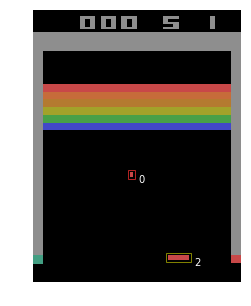


 Frame: 4


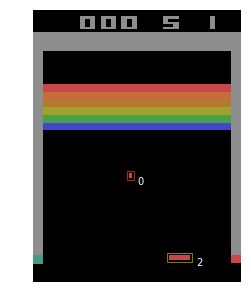


 Frame: 5


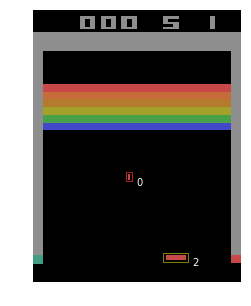

In [28]:
fp = mt.frame_pairs

for i in range(mt.cur_frame):
    print '\n Frame: ' + str(i)
    #print 'Action: ' + str(mt.action_hist[i]) + '\n'
    fig = plt.figure(figsize=(12,5))

    movers_cur_frame = []
    for m in mt.movers:
        cur_frame_pos = filter(lambda p: p[0]==i, m.trajectory)
        if len(cur_frame_pos) > 0:
            movers_cur_frame.append((m.id, cur_frame_pos[0][1]))
        
    ax = plt.gca()
    plt.axis('off')
    if i == 0:
        plt.imshow(fp[i].s0)
    else:
        plt.imshow(fp[i-1].s1)
    for data in movers_cur_frame:
        m_id = data[0]
        box = data[1]
        ax.add_patch(patches.Rectangle((box.ll.x-1, box.ll.y-1),
                                    box.width+1, box.height+1,
                                    color=box_colors[(m_id+1) % len(box_colors)],
                                    fill=False)
            )
        plt.text(box.ur.x+3, box.ur.y+3, str(m_id),color='w')
    plt.show()

## Finding movers

Let's look at how it did this.  We start by subtracting one frame from the next.  Shown below are two successive frames from the above output, along with their difference.

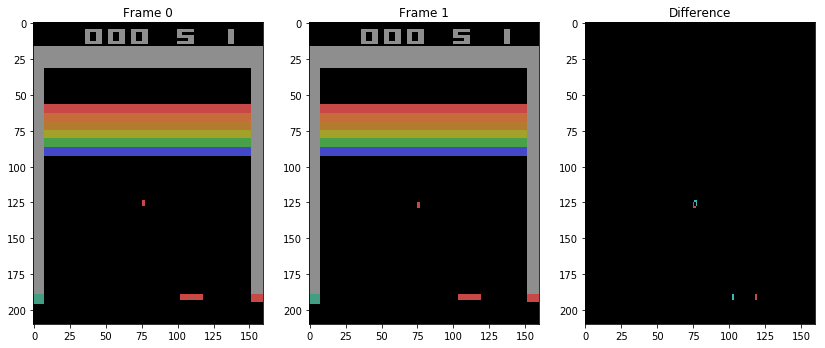

In [29]:
example_fp = fp[2]

plt.figure(figsize=(14,8))
plt.subplot(131)
plt.imshow(example_fp.s0)
plt.title('Frame 0')
plt.subplot(132)
plt.imshow(example_fp.s1)
plt.title('Frame 1');
plt.subplot(133)
plt.imshow(example_fp.s1-example_fp.s0)
plt.title('Difference');

Now we use OpenCV to do some processing to the frame difference.

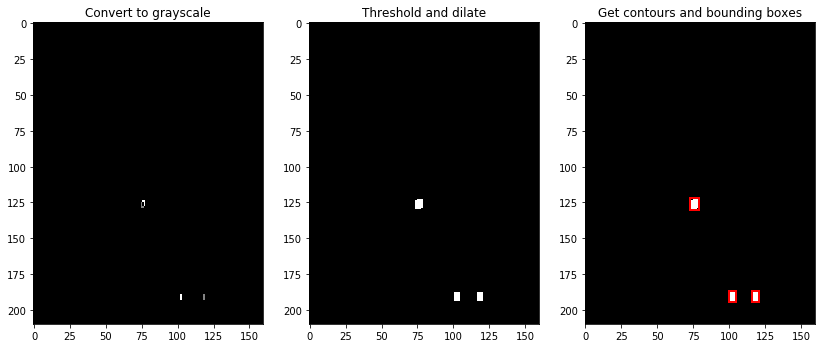

In [30]:
finder = example_fp.finder

# the next four lines are done internally by the 'finder' object we just got
# but not stored as attributes, so I'm re-doing them in the cell
frame_diff = example_fp.s1 - example_fp.s0
fd_grey = cv2.cvtColor(frame_diff, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(fd_grey,1,255,cv2.THRESH_BINARY)[1]
thresh_dilated = cv2.dilate(thresh,None,iterations=1)

plt.figure(figsize=(14,9))
plt.subplot(131)
plt.imshow(fd_grey,cmap='gray')
plt.title('Convert to grayscale')
plt.subplot(132)
plt.imshow(thresh_dilated,cmap='gray')
plt.title('Threshold and dilate')
plt.subplot(133)
plt.imshow(thresh_dilated,cmap='gray');
plt.title('Get contours and bounding boxes')
ax = plt.gca()
for cnt in finder.cnts:
    (x, y, w, h) = cv2.boundingRect(cnt)
    ax.add_patch(patches.Rectangle((x-1, y-1),
                                w+1, h+1,
                                color='r',
                                   lw=2,
                                fill=False)
        )
plt.show()

Hmm . . . subtracting the two frames removed the middle of the paddle at the bottom, so we only see the edges, and they look like two distinct objects.  To handle this, we form all possible *unions* of the bounding boxes.

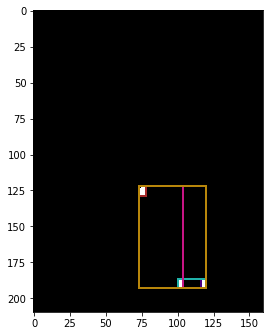

In [31]:
plt.figure(figsize=(14,9))

plt.subplot(131)
plt.imshow(finder.thresh_dilated,cmap='gray')
ax = plt.gca()
for i, box in enumerate(finder.cnts_joined):
    (x, y, w, h) = (box.ll.x, box.ll.y, box.width, box.height)
    ax.add_patch(patches.Rectangle((x-1, y-1),
                                w, h,
                                color=box_colors[2*i],
                                   lw=2,
                                fill=False)
        )
plt.show()

Now we've identified a bunch of regions in space (boxes).  For each region, we can look at what was going on there in the two successive frames.  Here's an example.

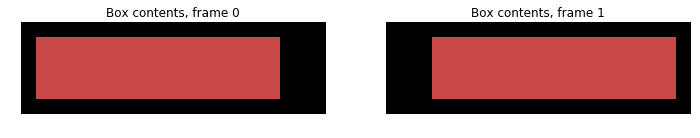

In [32]:
box = finder.cnts_joined[3]

plt.figure(figsize=(12,4))

box.add_image(example_fp.s0)
plt.subplot(121)
plt.imshow(box.img,interpolation='nearest')
plt.axis('off')
plt.title('Box contents, frame 0')

box.add_image(example_fp.s1)
plt.subplot(122)
plt.axis('off')
plt.imshow(box.img,interpolation='nearest')
plt.title('Box contents, frame 1');

Above, I've shown the kind of box we want to find -- one that contains an entire mover and the motion it made.  Of course, some boxes are not so useful:

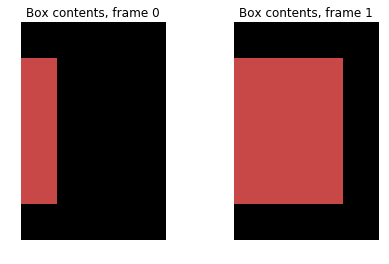

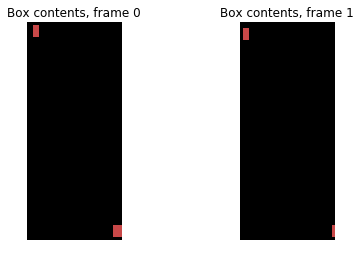

In [33]:
box = finder.cnts_joined[0]

plt.figure(figsize=(7,4))

box.add_image(example_fp.s0)
plt.subplot(121)
plt.imshow(box.img,interpolation='nearest')
plt.axis('off')
plt.title('Box contents, frame 0')

box.add_image(example_fp.s1)
plt.subplot(122)
plt.imshow(box.img,interpolation='nearest')
plt.axis('off')
plt.title('Box contents, frame 1');

box = finder.cnts_joined[5]

plt.figure(figsize=(7,4))

box.add_image(example_fp.s0)
plt.subplot(121)
plt.imshow(box.img,interpolation='nearest')
plt.axis('off')
plt.title('Box contents, frame 0')

box.add_image(example_fp.s1)
plt.subplot(122)
plt.imshow(box.img,interpolation='nearest')
plt.axis('off')
plt.title('Box contents, frame 1');

What we want, ideally, is a box whose contents on one frame are just a *translated* copy of their contents on the other.  The TranslationFinder class looks for these boxes.

First, it uses OpenCV's phaseCorrelate() to guess the appropriate translation.  Then it generates a translated version of the box contents on the first frame, and looks at how well (in squared error) this matches the contents on the second frame.  Finally, since we can't always get a perfect match this way -- some movers can change appearance, some can appear and disappear -- it uses some heuristics.

## Filters

If we successfully find a translation, we can use it to crop the bounding box and get a snapshot of the mover's sprite.  (The bounding box is larger than the sprite because it's big enough to cover where the mover is in *both* frames.)

For example:

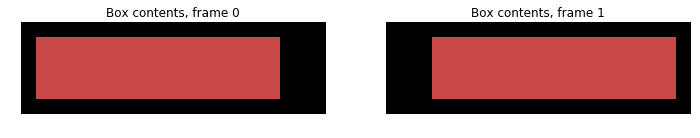

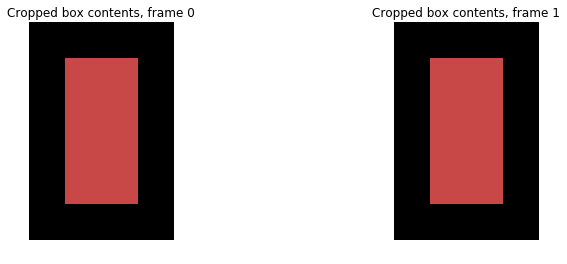

In [34]:
box = finder.cnts_joined[3]

plt.figure(figsize=(12,4))

box.add_image(example_fp.s0)
plt.subplot(121)
plt.imshow(box.img,interpolation='nearest')
plt.axis('off')
plt.title('Box contents, frame 0')

box.add_image(example_fp.s1)
plt.subplot(122)
plt.axis('off')
plt.imshow(box.img,interpolation='nearest')
plt.title('Box contents, frame 1');

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.axis('off')
plt.imshow(mt.movers[0].trajectory[1][1].img, interpolation='nearest')
plt.title('Cropped box contents, frame 0')

plt.subplot(122)
plt.axis('off')
plt.imshow(mt.movers[0].trajectory[2][1].img, interpolation='nearest')
plt.title('Cropped box contents, frame 1');

Note that the cropped images for the two frames are identical.  For each mover, Piaget stores a series of cropped snapshots, one per frame.  Often these will be identical, but it's worth keeping all of them, since some movers can change appearance (such as Ms. Pac-Man).

These sprites are the kind of structures we'd expect a ConvNet to learn to recognize.  We can jump-start that process by using the sprite images we've already identified as ConvNet filters.  The Prototyper class handles this process.

In [35]:
pt = Prototyper(mt.game_id)

When we create a Prototyper, we give it a game ID.  It loads the saved images and MoverTracker associated with that ID, and does two things:

First, it selects a representative snapshot of each mover to serve as our proxy for that mover's sprite, which I call a "prototype."  These will be used to make filters for the first layer of our ConvNet.

Second, it looks at the *trajectory* we observed for that mover, and generates a set of *displacements*, which will be used to make filters for a second layer that takes inputs from the first.

Here are the prototypes it made:

Mover 0


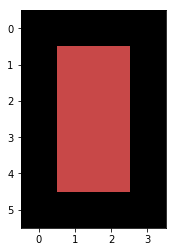

Mover 2


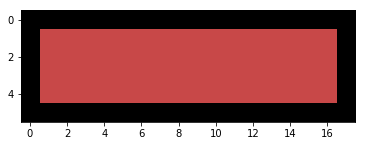

In [36]:
for i in range(len(pt.mover_ids)):
    m_id = pt.mover_ids[i]
    p = pt.mover_prototypes[i]
    plt.imshow(p,interpolation='nearest')
    print 'Mover %d' % m_id
    plt.show()

And here are the displacements it assigned to them:

In [37]:
for i in range(len(pt.mover_ids)):
    m_id = pt.mover_ids[i]
    print 'Mover %d' % m_id
    print pt.mover_disps[i]

Mover 0
[(-1, 1), (1, 1), (-1, -1), (1, -1)]
Mover 2
[(2, 0), (-2, 0), (1, 0), (-1, 0), (-3, 0), (3, 0)]


The ball (Mover 0) moves diagonally, while the paddle (Mover 2) moves horizontally.  (Not all of these displacements were actually observed in the 5 frames we saw: from each actually-observed displacement, the Prototyper froms four displacements by reflecting it around the x and y axes.)

## Nets

Now let's make some ConvNets.

There are currently two classes that build nets based on Prototyper information: ProtoQNetwork and ProtoModelNetwork.

ProtoQNetwork builds a four-layer, dueling Q-Network architecture.  It's intended to do deep Q-learning for the Atari games using a very similar setup to the one in DeepMind's DQN papers (see [here](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) and, for the Dueling architecture, [here](https://arxiv.org/pdf/1511.06581.pdf)).  The one difference here is that the first two layers are fixed (not trainable) and initialized from the prototyes and displacements we found.

The ProtoQNetwork code was adapted from Arthur Juliani's code in his repo [DeepRL-Agents](https://github.com/awjuliani/DeepRL-Agents), associated with his excellent series of [tutorials](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0).

ProtoModelNetwork builds a similar network architecture, but rather than outputting a Q value, it tries to predict what its own first layer will see on the *next* frame.  I'll go into more detail on that in a moment.

In [38]:
from nets import protoQnetwork, protoModelnetwork

In [43]:
from training import train_protoModelNetwork

(5081, 4488, 323.54616167416236)
('action: ', 3, 'old_action: ', 0)


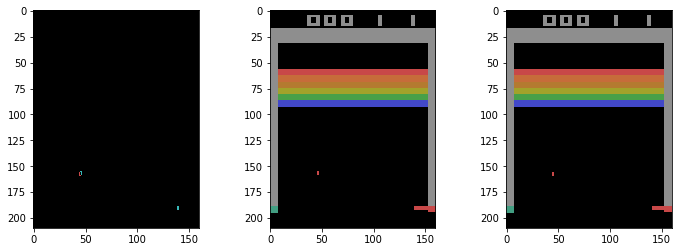

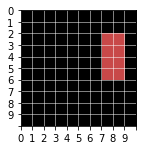

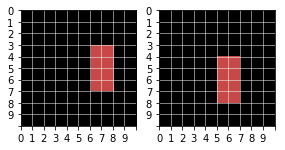

(True, True, 0.99996129540442302)


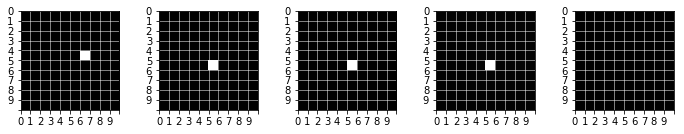

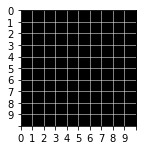

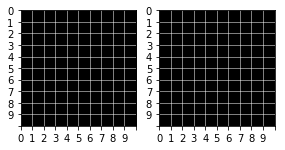

(False, False, 3.599516112408825e-09)


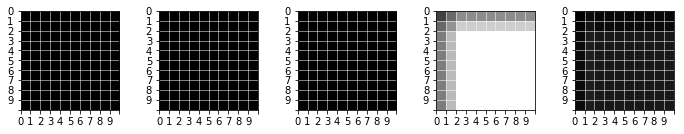

('action: ', 0, 'old_action: ', 2)


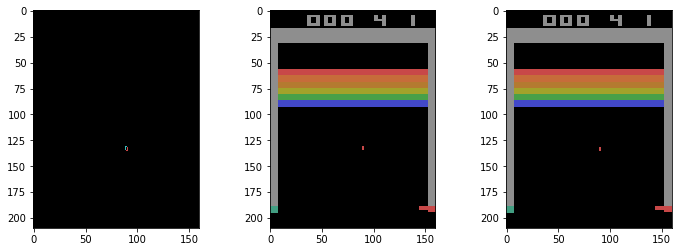

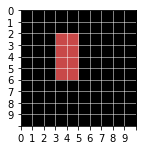

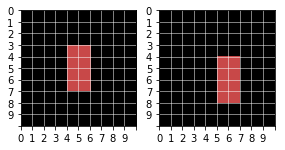

(True, True, 0.99996779820916759)


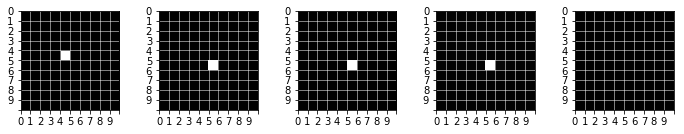

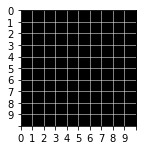

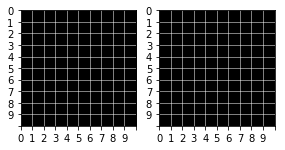

(False, False, 3.4740336839869577e-09)


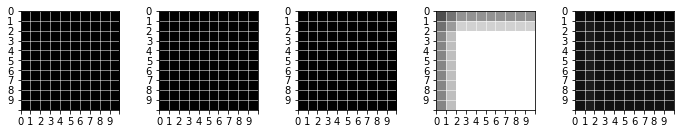

(6064, 5394, 112.01721572128822)
('action: ', 3, 'old_action: ', 1)


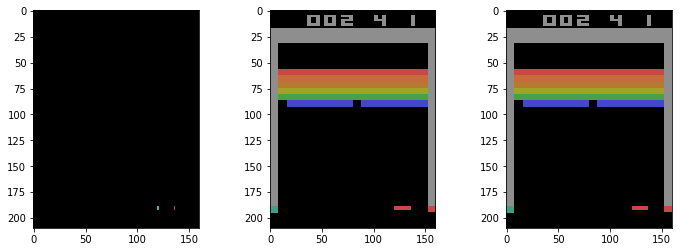

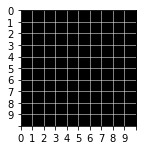

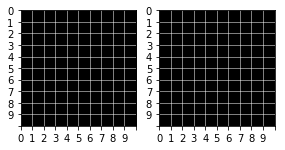

(False, False, 2.5727451216474239e-07)


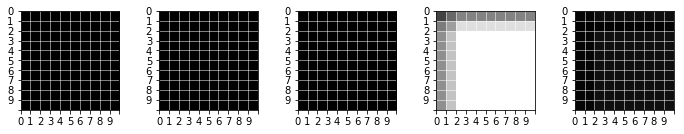

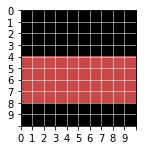

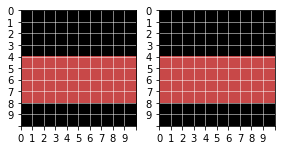

(True, True, 0.76980602354721328)


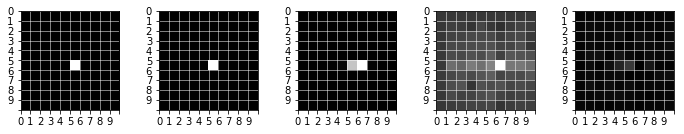

('action: ', 2, 'old_action: ', 0)


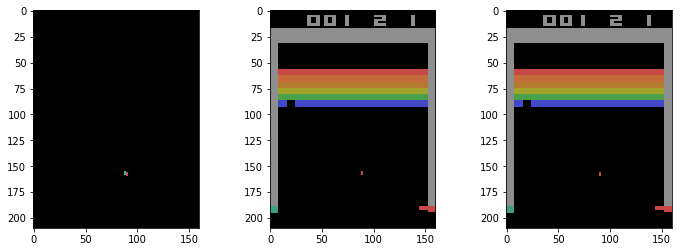

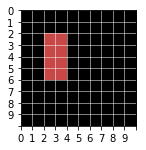

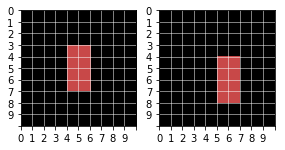

(True, True, 0.77570338434163644)


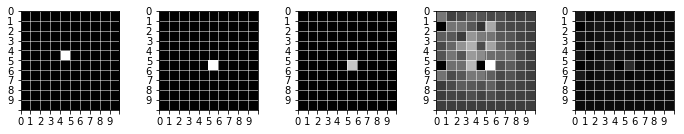

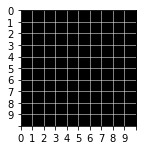

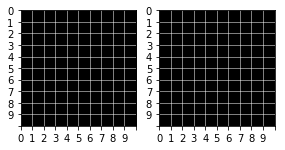

(False, False, 1.0174542888756264e-06)


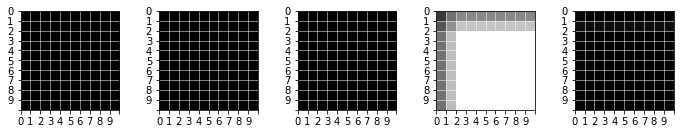

(6547, 5818, 97.551683818603465)
('action: ', 3, 'old_action: ', 3)


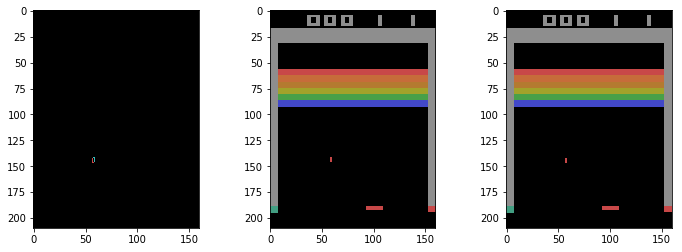

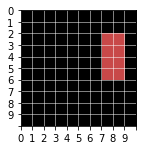

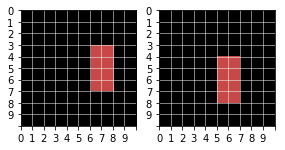

(True, True, 0.99962960989312555)


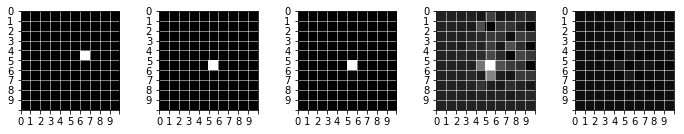

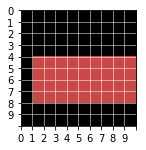

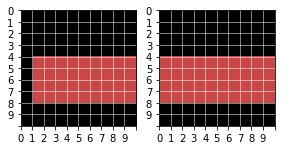

(True, True, 0.81063940206694696)


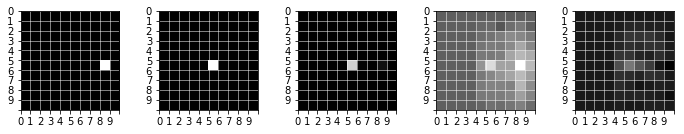

('action: ', 0, 'old_action: ', 3)


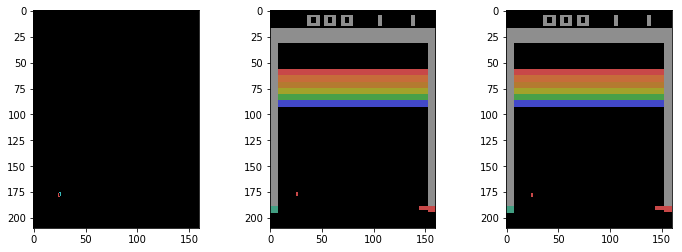

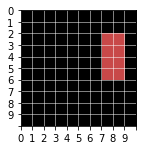

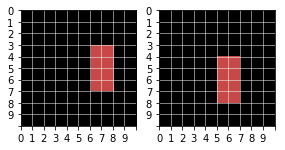

(True, True, 0.99943953930849638)


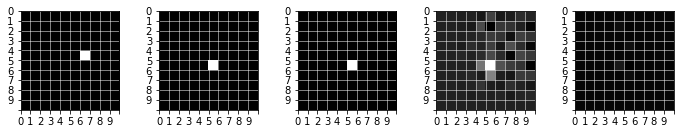

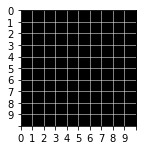

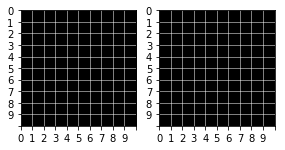

(False, False, 1.7306435620438454e-06)


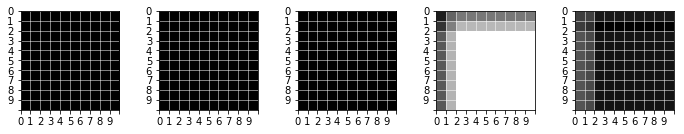

(7216, 6397, 76.688109489366482)
('action: ', 0, 'old_action: ', 3)


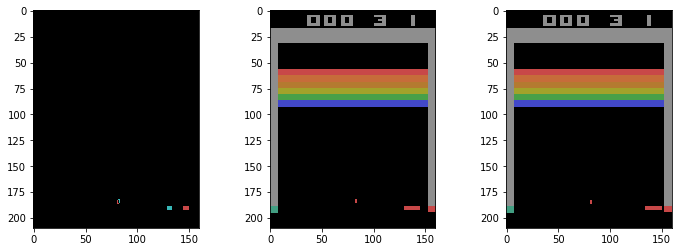

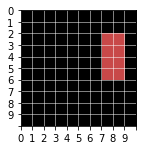

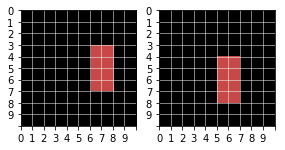

(True, True, 0.99101457112253988)


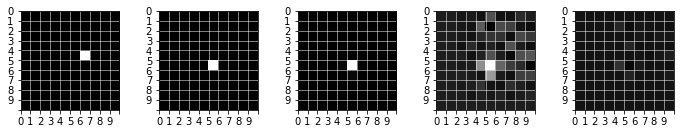

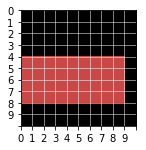

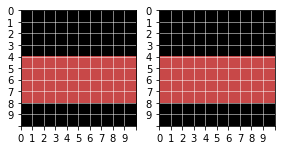

(True, True, 0.0062857488282673729)


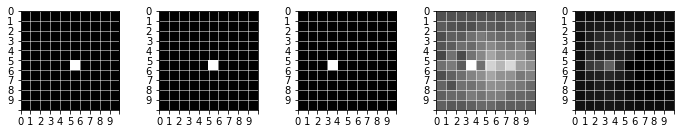

('action: ', 0, 'old_action: ', 2)


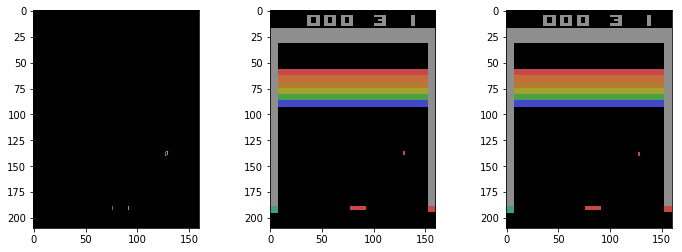

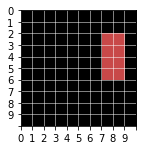

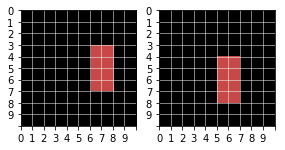

(True, True, 0.98515719272230928)


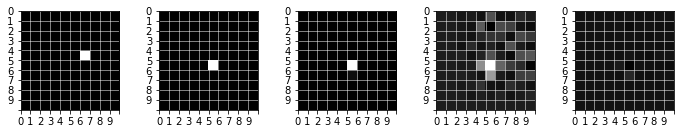

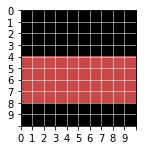

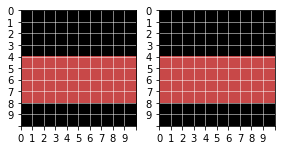

(True, True, 0.67644667912861711)


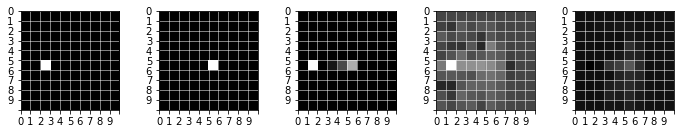

(8195, 7322, 48.333374587319796)
('action: ', 2, 'old_action: ', 1)


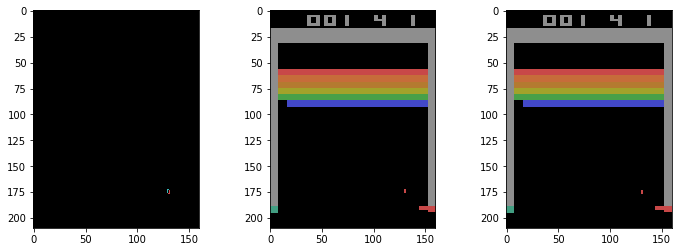

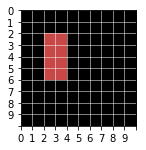

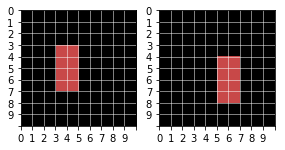

(True, True, 0.19206653018965306)


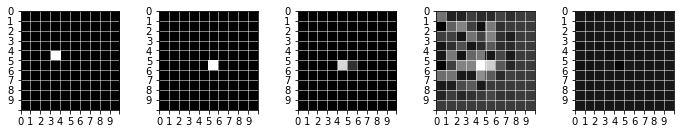

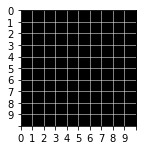

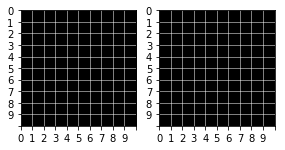

(False, False, 5.982650805428124e-07)


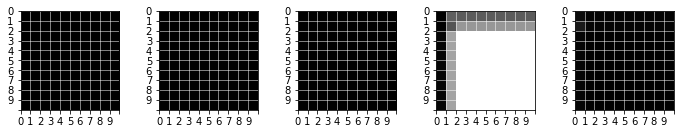

('action: ', 1, 'old_action: ', 2)


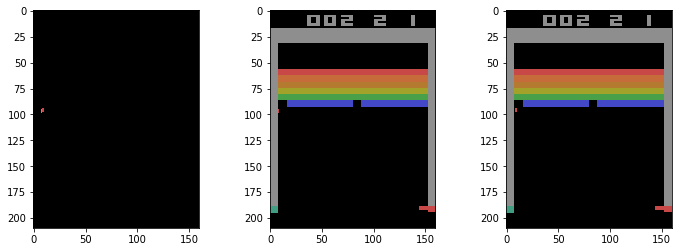

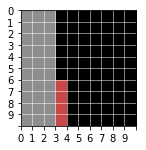

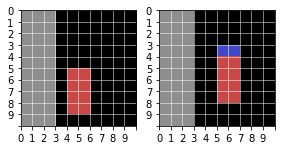

(True, True, 6.402732830986744e-05)


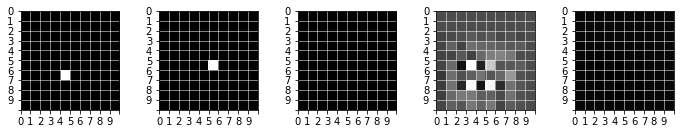

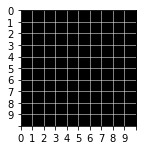

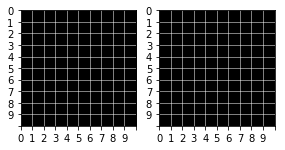

(False, False, 5.9570770069746911e-07)


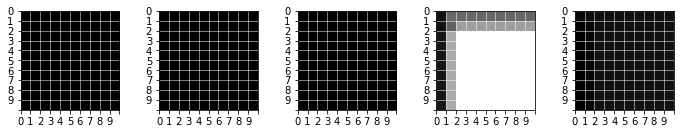

In [ ]:
train_protoModelNetwork(env, pt, breakout=True)